In [1]:
from __future__ import annotations

import math
import argparse
from pathlib import Path
import sys
from typing import Iterable, List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

FONT_SCALE = 1.4  # ← master knob
_BASE_FONT = 10

SECONDS_TO_HOUR = 3600
SECONDS_TO_DAY = 86_400

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=FONT_SCALE)

plt.rcParams.update({
    "font.size": _BASE_FONT * FONT_SCALE,
    "axes.titlesize": _BASE_FONT * FONT_SCALE * 1.2,
    "axes.labelsize": _BASE_FONT * FONT_SCALE,
    "xtick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "ytick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "legend.fontsize": _BASE_FONT * FONT_SCALE * 0.9,
})

from helper import (
    SCOPE_DIR,
    FIG_DIR,
    COLOR_MAP,
    NAME_MAPPING,
    FLOW_ORDER,
    mannUandCliffdelta,       # statistical tests
)  # type: ignore

In [2]:

##############################################################################
# CSV helpers
##############################################################################
def _load_csv(agent: str, name: str,
              scope_dir: Path = SCOPE_DIR,
              parse_dates=None) -> pd.DataFrame:
    base = scope_dir / agent
    fp = base / f"{name}.csv"
    if not fp.exists():
        fp = base / f"{name}_head.csv"
        if not fp.exists():
            raise FileNotFoundError(fp)
    return pd.read_csv(fp, parse_dates=parse_dates)


def load_prs(agent: str, scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    return _load_csv(agent, "prs", scope_dir,
                     parse_dates=["created_at", "closed_at", "merged_at"])


def load_labels(agent: str, scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    return _load_csv(agent, "gpt_conventional_commits", scope_dir)


##############################################################################
# Core analysis
##############################################################################
def analyze_agent(agent: str,
                  scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    prs = load_prs(agent, scope_dir)
    labels = load_labels(agent, scope_dir)

    df = prs.merge(labels[["id", "type"]], on="id", how="inner")

    # status & turnaround
    df["status"] = df.apply(
        lambda r: ("open" if r["state"] == "open"
                   else "merged" if pd.notna(r["merged_at"])
        else "closed"), axis=1)
    df["end_at"] = df["merged_at"].fillna(df["closed_at"])
    df["turnaround_hours"] = (
        df["end_at"] - df["created_at"]).dt.total_seconds() / 3600

    def summarise(group: pd.DataFrame) -> pd.Series:
        stats = {
            "total": len(group),
            "open_pct": 100 * (group["status"] == "open").mean(),
            "closed_pct": 100 * (group["status"] == "closed").mean(),
            "merged_pct": 100 * (group["status"] == "merged").mean(),
        }
        non_open = group[group["status"] != "open"]
        stats["median_hours"] = non_open["turnaround_hours"].median()
        stats["median_hours_closed"] = group[group["status"] == "closed"]["turnaround_hours"].median()
        stats["median_hours_merged"] = group[group["status"] == "merged"]["turnaround_hours"].median()
        return pd.Series(stats)

    return (df.groupby("type").apply(summarise)
            .sort_values("total", ascending=False))


##############################################################################
# Other high-level visualisations (unchanged)
##############################################################################
def gather_merged_pct(agents: Iterable[str],
                      scope_dir: Path = SCOPE_DIR,
                      min_instances: int = 5) -> pd.DataFrame:
    rows: list[pd.DataFrame] = []
    for ag in agents:
        try:
            summ = analyze_agent(ag, scope_dir)
        except FileNotFoundError:
            continue
        summ = summ.loc[(summ.index != "other") &
                        (summ["total"] >= min_instances)]
        if summ.empty:
            continue
        tmp = summ.reset_index()[["type", "merged_pct"]].copy()
        tmp["agent"] = ag
        rows.append(tmp)
    return (pd.concat(rows, ignore_index=True)
            if rows else pd.DataFrame(columns=["agent", "type", "merged_pct"]))


def plot_merged_pct_radar_all_in_one(df: pd.DataFrame, out_fp: Path) -> None:
    if df.empty:
        print("No data to plot.")
        return
    pref = ["Human", "OpenAI_Codex", "Devin",
            "Copilot", "Cursor", "Claude_Code"]
    nice = {"Human": "Human", "OpenAI_Codex": "OpenAI Codex",
            "Devin": "Devin", "Copilot": "GitHub Copilot",
            "Cursor": "Cursor", "Claude_Code": "Claude Code"}
    # cats   = sorted(df["type"].unique())
    # keep only categories that exist in the data, in the chosen order
    cats = [c for c in FLOW_ORDER if c in df["type"].unique()]
    theta = np.linspace(0, 2 * np.pi, len(cats), endpoint=False)[::-1]
    theta = np.concatenate([theta[4:], theta[:4]])  # move "feat" to the top
    theta = np.r_[theta, theta[0]]

    fig, ax = plt.subplots(figsize=(7, 7),
                           subplot_kw={"polar": True})
    for ag in (a for a in pref if a in df["agent"].unique()):
        s = df.loc[df["agent"] == ag].set_index("type")["merged_pct"]
        vals = [s.get(c, 0) for c in cats] + [s.get(cats[0], 0)]
        ax.plot(theta, vals, lw=2.5 if ag == "Human" else 1.5,
                label=nice[ag], color=COLOR_MAP[ag])
        ax.fill(theta, vals, alpha=.35 if ag == "Human" else .20,
                color=COLOR_MAP[ag])

    ax.set_xticks(theta[:-1])
    ax.set_xticklabels(cats)
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100]])
    ax.set_rlabel_position(90)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2),
              ncol=math.ceil(df["agent"].nunique() / 2), frameon=False)

    fig.tight_layout()
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_fp, dpi=300)
    fig.savefig(out_fp.with_suffix(".png"), dpi=300)
    plt.close(fig)
    print("Wrote", out_fp)


def _radar_trace(ax,
                 s: pd.Series,
                 cats: List[str],
                 theta: np.ndarray,
                 *,
                 label: str,
                 colour: str,
                 lw: float = 1.5,
                 fill: bool = True,
                 alpha: float = 0.25,
                 marker_size: float = 4.0) -> None:
    """
    Plot a *closed* radar trace on ``ax`` with optional fill and point markers.

    Parameters
    ----------
    ax          : Matplotlib polar Axes to draw on.
    s           : Series whose index are categories (cats) and whose values are
                  the metric to plot (e.g. merged_pct).
    cats        : List of category names in the *display* order.
    theta       : N+1 array of polar angles; last entry must equal first.
    label       : Text for this trace in the legend.
    colour      : RGB/hex colour for line/markers/fill.
    lw, fill, alpha, marker_size : Cosmetics.
    """
    # Pull values in display order; append first again so the loop closes
    vals = [s.get(c, 0) for c in cats] + [s.get(cats[0], 0)]

    # Line + circular markers
    ax.plot(theta,
            vals,
            lw=lw,
            color=colour,
            label=label,
            marker="o",
            markersize=marker_size,
            markerfacecolor=colour)

    if fill:
        ax.fill(theta, vals, alpha=alpha, color=colour)


# ── main --------------------------------------------------------------------

def plot_merged_pct_radar(df: pd.DataFrame,
                          out_fp: Path | str,
                          *,
                          font_size: int = 15) -> None:
    """
    Build a single figure (≤5 radar sub-plots) comparing *merged_pct* across
    agents and save it as <stem>.pdf and <stem>.png.

    Parameters
    ----------
    df        : Long-form DataFrame with columns ["agent", "type", "merged_pct"].
    out_fp    : Output *stem* (no extension).  Two files are written:
                <stem>.pdf and <stem>.png in ``df.to_csv(out_fp)``’s directory.
    font_size : Base font size for tick labels, etc.
    """
    if df.empty:
        print("❗  No data to plot.")
        return

    plt.rcParams.update({"font.size": font_size})

    # Preferred ordering of agents (show max five, excluding the baseline Human)
    pref_order = [
        "OpenAI_Codex",
        "Devin",
        "Copilot",
        "Cursor",
        "Claude_Code",
    ]
    pretty = {
        "Human": "Human",
        "OpenAI_Codex": "OpenAI Codex",
        "Devin": "Devin",
        "Copilot": "GitHub Copilot",
        "Cursor": "Cursor",
        "Claude_Code": "Claude Code",
    }

    # Categories actually present in the data, kept in FLOW_ORDER order
    cats = [c for c in FLOW_ORDER if c in df["type"].unique()]
    if not cats:
        print("❗  No recognised *type* categories found in the data.")
        return

    # Polar angles, rotated so 'feat' sits at 12 o’clock
    theta = np.linspace(0, 2 * np.pi, len(cats), endpoint=False)[::-1]
    theta = np.concatenate([theta[4:], theta[:4]])  # 'feat' to the top
    theta = np.r_[theta, theta[0]]  # close loop

    # Agents present, limited to five (baseline "Human" gets its own styling)
    agents: List[str] = [
                            a for a in pref_order if a in df["agent"].unique()
                        ][:5]
    if not agents:
        print("❗  No comparison agents found in the data.")
        return

    # ═══════════════  Figure layout (5 sub-plots)  ════════════════════════════
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(nrows=2, ncols=6)

    # Mapping of each subplot to its grid location
    slots = [
        (0, slice(0, 2)),  # row-0, cols 0-1
        (0, slice(2, 4)),  # row-0, cols 2-3
        (0, slice(4, 6)),  # row-0, cols 4-5
        (1, slice(1, 3)),  # row-1, cols 1-2
        (1, slice(3, 5)),  # row-1, cols 3-4
    ]

    # Pre-compute baseline (Human) percentages
    human_s = (
        df.loc[df["agent"] == "Human"]
        .set_index("type")["merged_pct"]
    )

    axes: list[plt.Axes] = []
    for agent, (r, csl) in zip(agents, slots):
        ax = fig.add_subplot(gs[r, csl], polar=True)
        axes.append(ax)

        # ── baseline (Human) trace
        _radar_trace(
            ax, human_s, cats, theta,
            label="Human",
            colour=COLOR_MAP["Human"],
            lw=2.5,
            fill=True,
            alpha=0.10,
        )

        # ── agent trace
        agent_s = (
            df.loc[df["agent"] == agent]
            .set_index("type")["merged_pct"]
        )
        _radar_trace(
            ax, agent_s, cats, theta,
            label=pretty[agent],
            colour=COLOR_MAP[agent],
            lw=1.5,
            fill=True,
            alpha=0.70,
        )

        # ── cosmetics ------------------------------------------------------
        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(cats, fontsize=font_size + 1)
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100]],
                           fontsize=font_size - 2)
        ax.set_rlabel_position(54)
        ax.text(
            0.5, -0.12, f"Human vs. " + pretty[agent],
            ha="center", va="top",
            fontsize=font_size + 1,
            transform=ax.transAxes,
        )

    # ════════════════  Consolidated rectangle legend  ════════════════════════
    legend_labels = ["Human"] + [pretty[a] for a in agents]
    legend_handles = [
                         Patch(facecolor=COLOR_MAP["Human"], alpha=0.6, edgecolor="none",
                               label="Human")
                     ] + [
                         Patch(facecolor=COLOR_MAP[a], alpha=0.6, edgecolor="none",
                               label=pretty[a])
                         for a in agents
                     ]

    fig.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc="lower left",
        bbox_to_anchor=(0.02, 0.01),
        # loc="lower right",
        # bbox_to_anchor=(0.98, 0.03),
        ncol=1,  # vertical
        fontsize=font_size,
        frameon=False,
    )

    fig.tight_layout()  # leave room for legend

    # ════════════════════  Save figure  ═════════════════════════════════════
    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    pdf_fp, png_fp = out_fp.with_suffix(".pdf"), out_fp.with_suffix(".png")
    fig.savefig(pdf_fp, dpi=300)
    fig.savefig(png_fp, dpi=300)
    plt.show()
    plt.close(fig)

    print(f"✓ wrote:\n  • {pdf_fp}\n  • {png_fp}")


def gather_median_hours(agents: Iterable[str],
                        scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    rows = []
    for ag in agents:
        try:
            summ = analyze_agent(ag, scope_dir)
        except FileNotFoundError:
            continue
        rows.append({
            "agent": ag,
            "median_hours_closed": summ["median_hours_closed"].median(),
            "median_hours_merged": summ["median_hours_merged"].median(),
        })
    return pd.DataFrame(rows)


##############################################################################
# Enhanced turnaround-comparison table helpers
##############################################################################
_STATUS_REMAP = {"closed": "Reject", "merged": "Accept"}
_PALETTE = {"Reject": "#DC267F", "Accept": "#0072B2"}


def gather_turnaround_distribution(
        agents: Iterable[str],
        scope_dir: Path = SCOPE_DIR,
) -> pd.DataFrame:
    """
    Return tidy DataFrame with columns:
        agent · status · turnaround_hours
    """
    frames: list[pd.DataFrame] = []
    for ag in agents:
        try:
            prs = load_prs(ag, scope_dir)
            lbls = load_labels(ag, scope_dir)
        except FileNotFoundError:
            continue

        df = prs.merge(lbls[["id"]], on="id", how="inner")
        df["status"] = df.apply(
            lambda r: ("open" if r["state"] == "open"
                       else "merged" if pd.notna(r["merged_at"])
            else "closed"), axis=1)
        df["end_at"] = df["merged_at"].fillna(df["closed_at"])
        df["turnaround_hours"] = (df["end_at"] - df["created_at"]
                                 ).dt.total_seconds() / SECONDS_TO_HOUR

        df = df[df["status"].isin(_STATUS_REMAP)]
        if df.empty:
            continue
        df["status"] = df["status"].map(_STATUS_REMAP)
        df["agent"] = ag
        frames.append(df[["agent", "status", "turnaround_hours"]])

    return (pd.concat(frames, ignore_index=True)
            if frames else pd.DataFrame())

def plot_turnaround_box(
        df: pd.DataFrame,
        out_fp: Path,
        *,
        log_scale: bool = True,
        baseline_agent: str = "Human",
) -> None:
    """
    Side-by-side box-plot of turnaround distributions (Accept vs Reject).

    – `baseline_agent` is pinned to the first position.
    – Remaining agents are ordered by *Accept* median (fastest → slowest).
    – Accept appears to the left of Reject in each cluster.
    – Underscores in agent names are replaced with spaces on the x-axis.
    """
    if df.empty:
        print("No data to plot.")
        return

    # ---------------------------------------------------------------
    # 1‒ Determine agent order (baseline first, then Accept median asc)
    # ---------------------------------------------------------------
    accept_medians = (df[df["status"] == "Accept"]
                      .groupby("agent")["turnaround_hours"]
                      .median()
                      .sort_values())

    ordered_agents = ([baseline_agent] +
                      [a for a in accept_medians.index
                       if a != baseline_agent])

    # ---------------------------------------------------------------
    # 2‒ Build the plot
    # ---------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 6))
    # print describe for each agent, Accept vs. Reject
    for ag in ordered_agents:
        ag_df = df[df["agent"] == ag]
        for status in ["Accept", "Reject"]:
            ag_status_df = ag_df[ag_df["status"] == status]
            if not ag_status_df.empty:
                print(f"{ag} ({status}):",
                      ag_status_df["turnaround_hours"].describe())

    sns.boxplot(
        data=df, x="agent", y="turnaround_hours",
        order=ordered_agents,
        hue="status",
        hue_order=["Accept", "Reject"],  # Accept left, Reject right
        palette=_PALETTE,
        showcaps=True, showfliers=True, width=0.65,
        saturation=0.8, linewidth=1.2, ax=ax,
        # set median line width and color
        medianprops={"linewidth": 2, "color": "#000000"},
        # set alpha for the box fill
        # boxprops={"alpha": 0.9},
    )

    # ---------------------------------------------------------------
    # 3‒ Cosmetic tweaks
    # ---------------------------------------------------------------
    ax.set_xlabel("")
    # ax.set_ylabel("Turnaround time (hours)" + (" (log scale)" if log_scale else ""))
    ax.set_ylabel("Turnaround Time")
    # ax.set_title("PR Turnaround Distributions – Accept vs Reject")
    if log_scale:
        ax.set_yscale("symlog")
    ax.set_ylim(-0.1)
    hours_yticks = [0, 1, 2, 8, 24, 24*3, 24*7, 24*30, 24*180]
    # hours_yticks = [0, 1, 2, 4, 8, 12, 24, 48, 72, 168, 720]
    ax.set_yticks(hours_yticks)
    ax.set_yticklabels([
        f"{h}h" if h < 24 else f"{h // 24}d" if h < 24 * 30 else f"{h // (24 * 30)}mo"
        for h in hours_yticks
    ])  # hours

    # Legend – de-duplicate
    handles, labels = ax.get_legend_handles_labels()
    uniq = [(h, l) for i, (h, l) in enumerate(zip(handles, labels))
            if l not in labels[:i]]
    ax.legend(*zip(*uniq),
              frameon=False, ncol=2,
              loc="upper right")

    # Replace underscores with spaces in x-axis labels
    ax.set_xticklabels([NAME_MAPPING[lbl.get_text()]
                        for lbl in ax.get_xticklabels()])

    fig.tight_layout()
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_fp, dpi=300)
    fig.savefig(out_fp.with_suffix(".png"), dpi=300)
    plt.show()
    plt.close(fig)
    print("Wrote", out_fp)
    print("Wrote", out_fp.with_suffix(".png"))

##############################################################################
# ──────────────── Enhanced table (FIXED Accept/Reject rate) ────────────────
##############################################################################
def _signif(p: float, alpha: float = .05) -> str:   # ‘*’ when significant
    return "*" if p < alpha else ""


def _agent_stats(agent: str, scope_dir: Path) -> dict[str, float]:
    """
    Return counts & medians for *all* labeled PRs of one agent.
    Keys: total, accept_cnt, reject_cnt, accept_rate, reject_rate,
          accept_median, reject_median
    """
    prs = load_prs(agent, scope_dir)
    lbls = load_labels(agent, scope_dir)
    df = prs.merge(lbls[["id"]], on="id", how="inner")

    # status
    df["status"] = np.select(
        [df["state"] == "open",
         pd.notna(df["merged_at"])],
        ["open", "merged"],
        default="closed",
    )
    # turnaround
    df["end_at"] = df["merged_at"].fillna(df["closed_at"])
    df["turnaround_hours"] = (
        df["end_at"] - df["created_at"]).dt.total_seconds() / SECONDS_TO_HOUR

    total = len(df)
    accept_cnt = (df["status"] == "merged").sum()
    reject_cnt = (df["status"] == "closed").sum()

    out: dict[str, float] = {
        "total": total,
        "accept_cnt": accept_cnt,
        "reject_cnt": reject_cnt,
        "accept_rate": 100 * accept_cnt / total if total else np.nan,
        "reject_rate": 100 * reject_cnt / total if total else np.nan,
        "accept_median": df.loc[df["status"] == "merged",
                                "turnaround_hours"].median(),
        "reject_median": df.loc[df["status"] == "closed",
                                "turnaround_hours"].median(),
    }
    return out


def build_enhanced_table(agents: list[str],
                         dist_df: pd.DataFrame,
                         *,
                         baseline: str = "Human",
                         scope_dir: Path = SCOPE_DIR) -> pd.DataFrame:
    """
    Multi-index columns:
        ┌──────────────┬──────────────────────────────┐
        │    Accept    │            Reject           │
        │ Sig   Cliff  │  Rate  Med  │ Sig   Cliff   │
        └──────────────┴──────────────────────────────┘
    """
    # ── per-agent global counts / medians ────────────────────────────────
    global_stats = {ag: _agent_stats(ag, scope_dir) for ag in agents}

    # ── significance & Cliff size vs baseline ────────────────────────────
    sig_map: Dict[str, Dict[str, str]] = {"Accept": {}, "Reject": {}}
    cliff_map: Dict[str, Dict[str, str]] = {"Accept": {}, "Reject": {}}

    for status in ["Accept", "Reject"]:
        base = dist_df[(dist_df["agent"] == baseline) &
                       (dist_df["status"] == status)]["turnaround_hours"]
        if base.empty:
            continue
        print("Baseline turnaround hours:")
        print(base.describe())

        base = base.to_numpy()

        for ag in agents:
            if ag == baseline:
                sig_map[status][ag] = ""
                cliff_map[status][ag] = ""
                continue
            sample = dist_df[(dist_df["agent"] == ag) &
                             (dist_df["status"] == status)]["turnaround_hours"]
            if sample.empty:
                sig_map[status][ag] = ""
                cliff_map[status][ag] = ""
                continue
            u, p, _, size = mannUandCliffdelta(sample.to_numpy(), base)
            print("", ag, status, "→ Cliff size:", size, "p-value:", p)
            print("Sample turnaround hours:")
            print(sample.describe())
            sig_map[status][ag] = _signif(p)
            cliff_map[status][ag] = size

    # ── assemble DataFrame ───────────────────────────────────────────────
    rows: Dict[str, Dict[tuple[str, str], Any]] = {}
    for ag in agents:
        gs = global_stats.get(ag, {})
        rows[ag] = {
            ("Accept", "Rate"):  round(gs.get("accept_rate", np.nan), 2),
            ("Accept", "Med"):   round(gs.get("accept_median", np.nan), 2),
            ("Accept", "Sig"):   sig_map["Accept"].get(ag, "-"),
            ("Accept", "Cliff"): cliff_map["Accept"].get(ag, "-"),

            ("Reject", "Rate"):  round(gs.get("reject_rate", np.nan), 2),
            ("Reject", "Med"):   round(gs.get("reject_median", np.nan), 2),
            ("Reject", "Sig"):   sig_map["Reject"].get(ag, "-"),
            ("Reject", "Cliff"): cliff_map["Reject"].get(ag, "-"),
        }

    cols = pd.MultiIndex.from_product(
        [["Accept", "Reject"],
         ["Rate", "Med", "Sig", "Cliff"]],
        names=["Status", ""],
    )
    df = pd.DataFrame.from_dict(rows, orient="index", columns=cols)
    df.index.name = "Agent"
    return df


def save_enhanced_table(df: pd.DataFrame, out_fp: Path) -> None:
    """Write CSV + ready-to-use LaTeX."""
    out_fp.parent.mkdir(parents=True, exist_ok=True)

    csv_df = df.copy()
    csv_df.columns = ['_'.join(c).lower() for c in csv_df.columns]
    csv_df.to_csv(out_fp, index=True)
    print(f"✓ CSV:  {out_fp}")

    latex = df.to_latex(
        escape=False, multirow=True, float_format="%.2f",
        caption="Turnaround statistics vs Human (\"*\" denotes $p<0.05$).",
        label="tab:turnaround_enhanced",
    )
    tex_fp = out_fp.with_suffix(".tex")
    print(latex)
    tex_fp.write_text(latex)
    print(f"✓ LaTeX: {tex_fp}")

In [3]:

##############################################################################
# ──────────────────────────────── CLI entry ────────────────────────────────
##############################################################################
def get_agents(scope_dir: Path = SCOPE_DIR) -> list[str]:
    return [d.name for d in scope_dir.iterdir()
            if d.is_dir() and (d / "prs.csv").exists()]

In [4]:
agents = get_agents()

for ag in agents:
    try:
        summ = analyze_agent(ag)
    except FileNotFoundError as e:
        print(e);
        continue
    if summ.empty:
        print(f"No labelled PRs for {ag}");
        continue
    print(f"\n=== {ag} ===")
    # print(summ.to_string(float_format="%.2f"))
    print(summ[["total", "merged_pct"]].to_string(float_format="%.2f"))

/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)
/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)



=== Cursor ===
          total  merged_pct
type                       
feat      60.00       48.33
fix       50.00       52.00
docs      10.00       60.00
chore      6.00       83.33
build      5.00       60.00
refactor   4.00       25.00
test       4.00       25.00
other      2.00        0.00
style      2.00      100.00
perf       1.00      100.00

=== Claude_Code ===
          total  merged_pct
type                       
feat      50.00       44.00
fix       19.00       36.84
docs      14.00       85.71
refactor   9.00       55.56
build      3.00      100.00
test       3.00       66.67
ci         2.00       50.00
chore      1.00      100.00


/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)
/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)



=== Human ===
           total  merged_pct
type                        
feat     1946.00       73.48
fix      1778.00       82.40
chore     847.00       78.98
build     614.00       73.45
docs      519.00       76.49
refactor  369.00       78.32
test      183.00       68.85
other     115.00       53.91
ci        100.00       82.00
perf       88.00       64.77
style      59.00       89.83

=== OpenAI_Codex ===
          total  merged_pct
type                       
feat     762.00       48.95
fix      731.00       65.25
docs     572.00       88.64
test     246.00       62.20
refactor 191.00       61.78
chore     71.00       78.87
build     43.00       62.79
ci        30.00       63.33
style     22.00       72.73
perf      16.00       50.00
other      2.00        0.00

=== Copilot ===
          total  merged_pct
type                       
fix      617.00       34.20
feat     434.00       34.56
docs     144.00       57.64
refactor  76.00       50.00
test      64.00       25.00
build    

/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)
/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)


/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)
/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (df.groupby("type").apply(summarise)
/tmp/ipykernel_82382/2977039326.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future versio

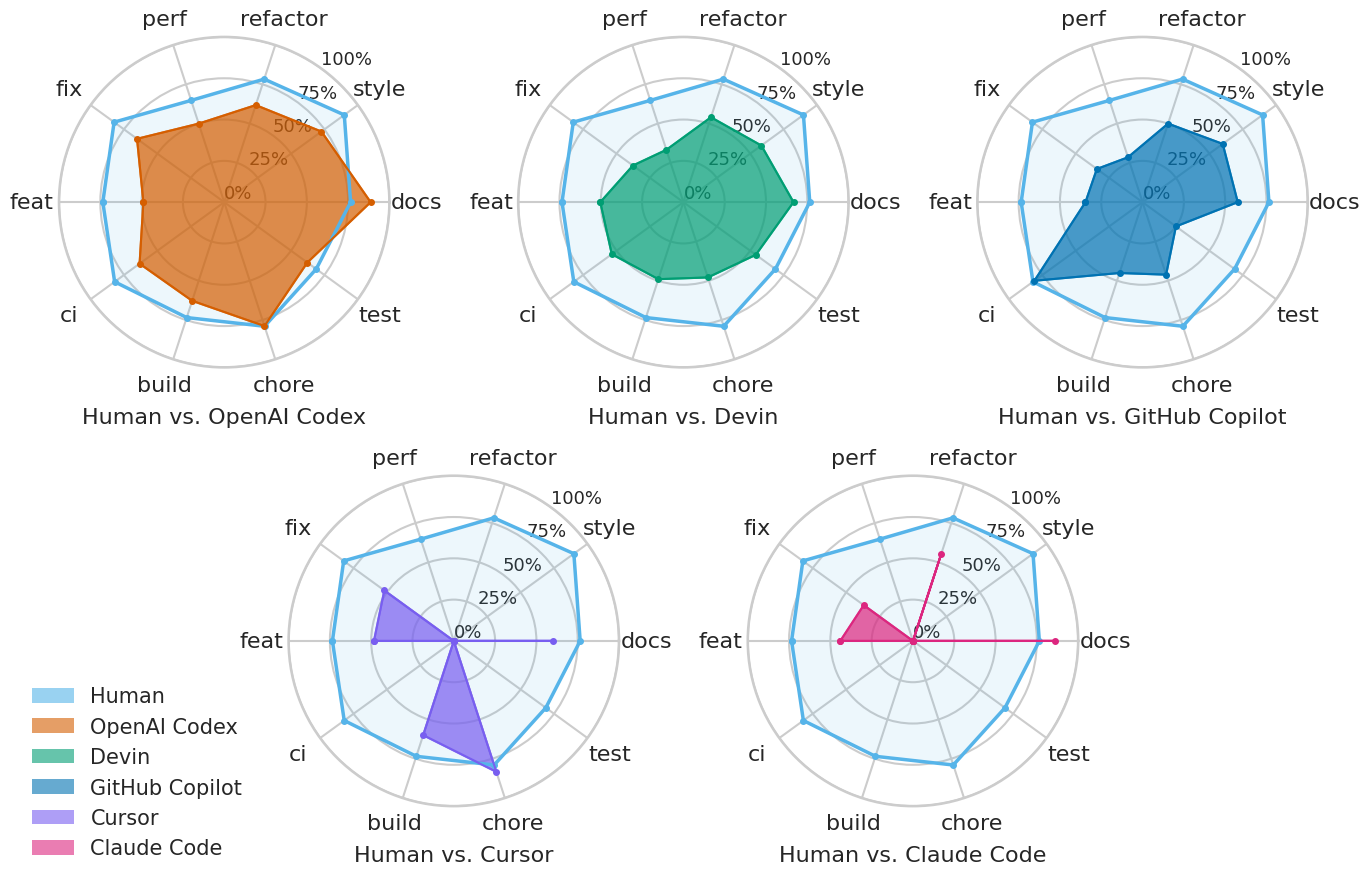

✓ wrote:
  • /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/pr_merge_compare_radar.pdf
  • /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/pr_merge_compare_radar.png


In [5]:

plot_merged_pct_radar(
    gather_merged_pct(agents),
    FIG_DIR / "pr_merge_compare_radar.pdf"
)

Human (Accept): count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
Name: turnaround_hours, dtype: float64
Human (Reject): count    1068.000000
mean      233.190097
std       488.981769
min         0.000278
25%         1.241042
50%        27.554722
75%       190.819236
max      3815.923333
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Accept): count    1754.000000
mean       21.397779
std        65.909498
min         0.001389
25%         0.041181
50%         0.292083
75%         7.691042
max       709.260000
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Reject): count    571.000000
mean      59.502769
std      111.824801
min        0.001111
25%        0.221111
50%        2.387222
75%       54.956250
max      717.213611
Name: turnaround_hours, dtype: float64
Devin (Accept): count    1335.000000
mean       48.794243
std       175.239169
min         0.005000
25

/tmp/ipykernel_82382/2977039326.py:471: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([NAME_MAPPING[lbl.get_text()]


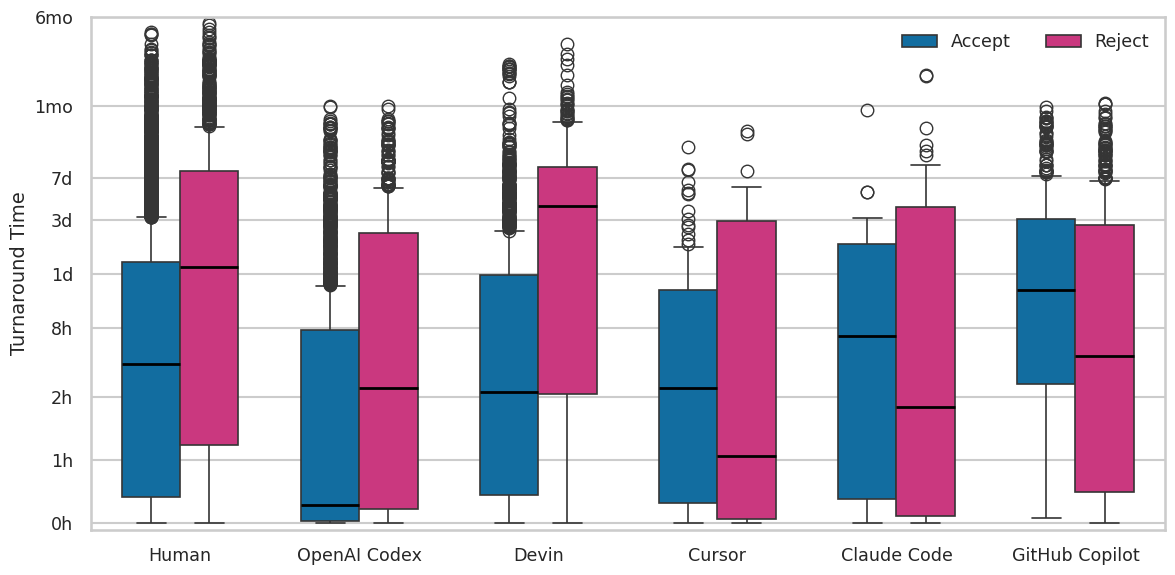

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/turnaround_distribution.pdf
Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/turnaround_distribution.png


In [6]:
plot_turnaround_box(
    gather_turnaround_distribution(agents),
    FIG_DIR / "turnaround_distribution.pdf",
    log_scale=True,
    )

In [7]:

dist_df = gather_turnaround_distribution(agents)
table_df = build_enhanced_table(agents, dist_df)
save_enhanced_table(table_df, FIG_DIR / "turnaround_enhanced.csv")



Baseline turnaround hours:
count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
Name: turnaround_hours, dtype: float64
Cliff's delta: negligible, d=-0.10000691500396283
Mann-Whitney-U-test: u=169196.0 p=0.139099351884748
 Cursor Accept → Cliff size: negligible p-value: 0.139099351884748
Sample turnaround hours:
count     74.000000
mean      26.286881
std       55.910909
min        0.001667
25%        0.326042
50%        2.408194
75%       17.392292
max      310.900000
Name: turnaround_hours, dtype: float64
Cliff's delta: negligible, d=-0.006275692275699703
Mann-Whitney-U-test: u=133801.5 p=0.9372953332791091
 Claude_Code Accept → Cliff size: negligible p-value: 0.9372953332791091
Sample turnaround hours:
count     53.000000
mean      33.187956
std       93.310865
min        0.003333
25%        0.377500
50%        6.873611
75%       43.884722
max      663.741667
Name: turna